In [2]:
import numpy as np
data1 = [1.2,1.3,1.4,1.8,1.8,1.9,2.2,1.9,1.9,1.7,1.6,1.3]


In [3]:
import pandas as pd
import numpy as np
def ul_line(data):
  #累積需要の下限と上限を作成する。x軸は経過時間で0から始まる。
  dataX =[]
  n = len(data)
  #print("ul_line,n:",n)
  for i in range(len(data)):
    dataX = np.append(dataX,data[i] * 10.0)
  if n < 3:
    raise Exception('データの件数が３未満です。')
    sys.exit(1)
  x = [0]
  g1 = [0.0]
  g2 = [1.0]
  count_minus = 0
  for i in range(1,n+1):
    if np.isnan(dataX[i-1]) :
      raise Exception('データに欠測値があります。')
      sys.exit(1)
    if dataX[i-1] < 1.0:
      dataX[i-1] = 0.0
      count_minus = count_minus + 1
    x.append(x[i-1]+1)
    g1.append(g1[i-1]+float(dataX[i-1]))
    g2.append(g1[i]+1.0)
  if count_minus == n:
    raise Exception('すべて値が0.1よりも小さいデータです。')
    sys.exit(1)    
  return x,g1,g2

def CheckContact(pos,ts,te,g1,g2):
  #時点tsとteの間でf1あるいはf2が階段曲線g1あるいはg2と接していないかどうか調べる。
  #f1が接しているときはcontact1 = 1、f2が接しているときはcontact2 = 1が返される。
  global t,tpos,ycum
  contact1 = 0
  contact2 = 0
  if pos==1:  #起点が下の場合。
    for i in range(1,te-ts):
      f1x = (g1[te]-g1[ts])*(te-i)/(te-ts) + (ts*g1[te]-te*g1[ts])/(ts-te)
      f2x = (g2[te]-g1[ts])*(te-i)/(te-ts) + (ts*g2[te]-te*g1[ts])/(ts-te)
      if f1x < g1[te-i] or f1x > g2[te-i]:
        contact1 = 1
      if f2x > g2[te-i] or f2x < g1[te-i]:
        contact2 = 1
  else:      #起点が上の場合。
    for i in range(1,te-ts):
      f1x = (g1[te]-g2[ts])*(te-i)/(te-ts) + (ts*g1[te]-te*g2[ts])/(ts-te)
      f2x = (g2[te]-g2[ts])*(te-i)/(te-ts) + (ts*g2[te]-te*g2[ts])/(ts-te)
      if f1x < g1[te-i] or f1x > g2[te-i]:
        contact1 = 1
      if f2x > g2[te-i] or f2x < g1[te-i]:
        contact2 = 1
  return contact1,contact2

def CalcY(pos1,x1,x2,g1,g2,pos2):
  #yiの計算をする。
  global ycum
  if pos1 == 1:
    #線分の起点は下。
    y1 = g1[x1]
  else:
    #線分の起点は上。
    y1 = g2[x1]
  if pos2 == 1:
    #線分の終点は下。
    y2 = g1[x2]
  else:
    #線分の終点は上。
    y2 = g2[x2]
  #print("y1,y2,x1+1,x2+1,pos1,pos2:",y1,y2,x1+1,x2+1,pos1,pos2)
  for i in range(x1+1,x2+1):   
    y[i] = (y2-y1)*(i-x1)/(x2-x1) + y1 - ycum
    ycum = ycum + y[i]

def CalcYEnd(g1,g2,ts,p):
  #yiの最後のところの計算をする。
  #パラメータpにより以下のような値を返す。
  #p=0 : 欠測値
  #p=1 : 下限値
  #P=2 : 上限値
  #P=3 : 下限値と上限値との中間値
  global t,tpos,y,ycum
  n = len(g1)
  if ts < n:
    for i in range(ts+1,n):
      if p == 1:
        ycum1 = g1[i]
      elif p == 2:
        ycum1 = g2[i]
      elif p == 3:
        ycum1 = (g1[i] + g2[i])/2.0
      else:
        y[i] = np.nan
      if p >= 1 and p <= 3:
        y[i] = ycum1 - ycum
        ycum = ycum + y[i]

def a_route(pos,ts,te,g1,g2,p):
  global t,tpos,y
  #teがデータの長さ以上の場合は終了。
  n = len(g1)
  if te >= n:
    CalcYEnd(g1,g2,ts,p)
    return t,tpos
  #te>ts+1かどうかの確認。
  if te-ts < 2:
    te = te + 1
  #下限直線f1のf1[te-1]、上限直線f2のf2[te-1]を計算する。
  contact1,contact2 = CheckContact(pos,ts,te,g1,g2)
  if contact1 == 0 or contact2 == 0:
    #前の時点で下限直線も上限直線の両方またはどちらかが接触しない場合は１つ先に進める。
    a_route(pos,ts,te+1,g1,g2,p)
  else:
    #上も下も接触する。
    #t1-1の時点で、上か下のどちらが接触していないか確認する。
    contact1,contact2 = CheckContact(pos,ts,te-1,g1,g2)
    posx = pos
    if contact1 == 0:
      pos = 1
    else:
      pos = 2
    #yの計算。
    CalcY(posx,ts,te-1,g1,g2,pos)

    #起点をte-1に置き換える。
    ts = te - 1
    te = te + 1      
    a_route(pos,ts,te,g1,g2,p)
    #接触点の出力。
    t.append(ts)
    tpos.append(pos)
t = []
tpos = []
ycum = 0.0
y = []
def a_route_m(data,p=0):
  #KWのデータを入力すると、上限需要、下限需要、推定値などを計算する。
  dataY = data
  x,g1,g2 = ul_line(dataY)
  #print(x)
  #print(g1)
  #print(g2)
  global y
  global ycum
  global t
  global tpos
  t = []
  tpos = [] 
  ycum = 0.0
  y = [0.0]
  for i in range(len(dataY)):
    y = np.append(y,0.0)
  if p <= 0 or p > 3:
    a_route(1,0,2,g1,g2,0)
  else:
    a_route(1,0,2,g1,g2,p) 
  return x,g1,g2,t,tpos,y,ycum


import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
def graphA(x,g1,g2,t,tpos):
  N = len(x) # 線の数
  lines = [[(x[i], g1[i]), (x[i+1], g1[i])] for i in range(N-1)]
  lines2 = [[(x[i], g1[i-1]), (x[i], g1[i])] for i in range(1,N-1)]
  lines3 = [[(x[i], g2[i+1]), (x[i+1], g2[i+1])] for i in range(N-1)]
  lines4 = [[(x[i], g2[i]), (x[i], g2[i+1])] for i in range(1,N-1)]

  lines6 = [[(x[N-1], g1[N-2]), (x[N-1], g1[N-1])]]
  #print(lines6)

  p = [(x[0], g1[0])]
  for i in range(len(t)):
    j = len(t)-i-1
    if tpos[j]==1:
      p.append((t[j], g1[t[j]]))
    else:
      p.append((t[j], g2[t[j]]))
  #print(p)
  lines5 = []
  for i in range(len(t)):
    lines5.append([p[i],p[i+1]])
  #print(lines5)
  lc = mc.LineCollection(lines,linewidths=1)
  lc2 = mc.LineCollection(lines2,linewidths=1)
  lc3 = mc.LineCollection(lines3,linewidths=1)
  lc4 = mc.LineCollection(lines4,linewidths=1)
  lc5 = mc.LineCollection(lines5,linewidths=1)
  lc6 = mc.LineCollection(lines6,linewidths=1)
  #描画
  fig = plt.figure(figsize=(20,10))
  ax = fig.add_subplot(1, 1, 1, aspect='auto')
  ax.add_collection(lc)
  ax.add_collection(lc2)
  ax.add_collection(lc3)
  ax.add_collection(lc4)
  ax.add_collection(lc5)
  ax.add_collection(lc6)
  ax.autoscale()
  plt.grid(b=True, color='#666666', linestyle='-')
  plt.show()

[1.2, 2.1, 1.0, 0.5, 1.5, 0.2, 0.2, 1.0, 1.1]
[7, 5, 4, 3, 2, 1]
[1, 1, 1, 1, 1, 1]
[0.0, 12.0, 33.0, 43.0, 48.0, 63.0, 65.0, 67.0, 77.0, 88.0]
[1.0, 13.0, 34.0, 44.0, 49.0, 64.0, 66.0, 68.0, 78.0, 89.0]
[ 0. 12. 21. 10.  5. 15.  2.  2. nan nan]


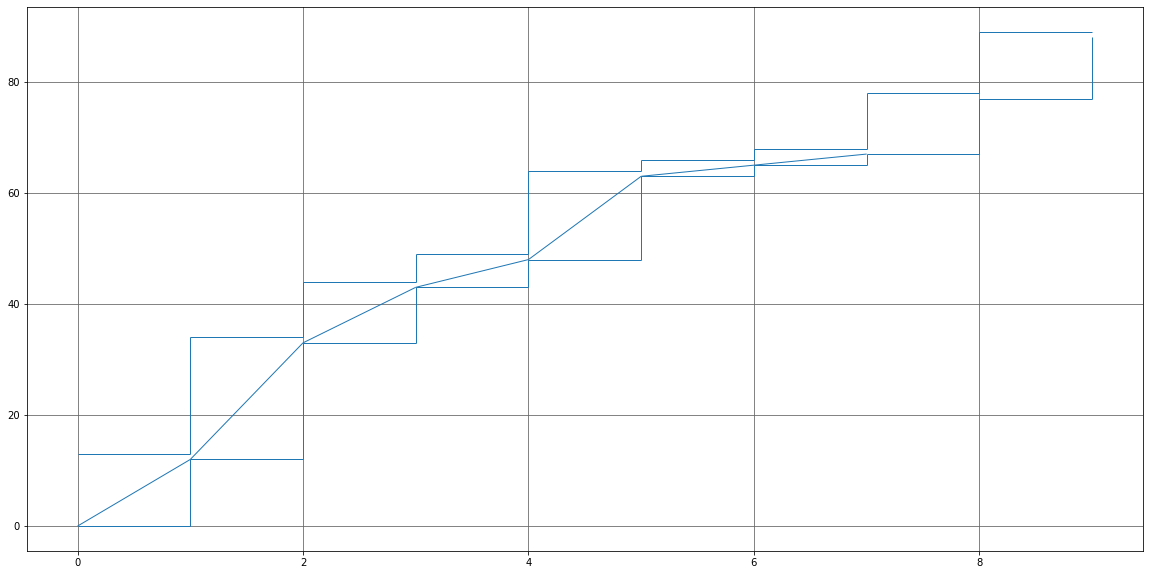

In [5]:
data1 = [1.2,2.1,1.0,0.5,1.5,0.2,0.2,1.0,1.1]
print(data1)
x,g1,g2,t,tpos,y,ycum = a_route_m(data1,0)
print(t)
print(tpos)
print(g1)
print(g2)
print(y)
graphA(x,g1,g2,t,tpos)

[1.2, 1.3, 1.4, 1.8, 1.8, 1.9, 2.2, 1.9, 1.9, 1.7, 1.6, 1.3]
[11, 9, 7, 6, 3]
[2, 1, 1, 1, 1]
[0.0, 12.0, 25.0, 39.0, 57.0, 75.0, 94.0, 116.0, 135.0, 154.0, 171.0, 187.0, 200.0]
[1.0, 13.0, 26.0, 40.0, 58.0, 76.0, 95.0, 117.0, 136.0, 155.0, 172.0, 188.0, 201.0]
[ 0.         13.         13.         13.         18.33333333 18.33333333
 18.33333333 22.         19.         19.         17.         17.
 12.5       ]


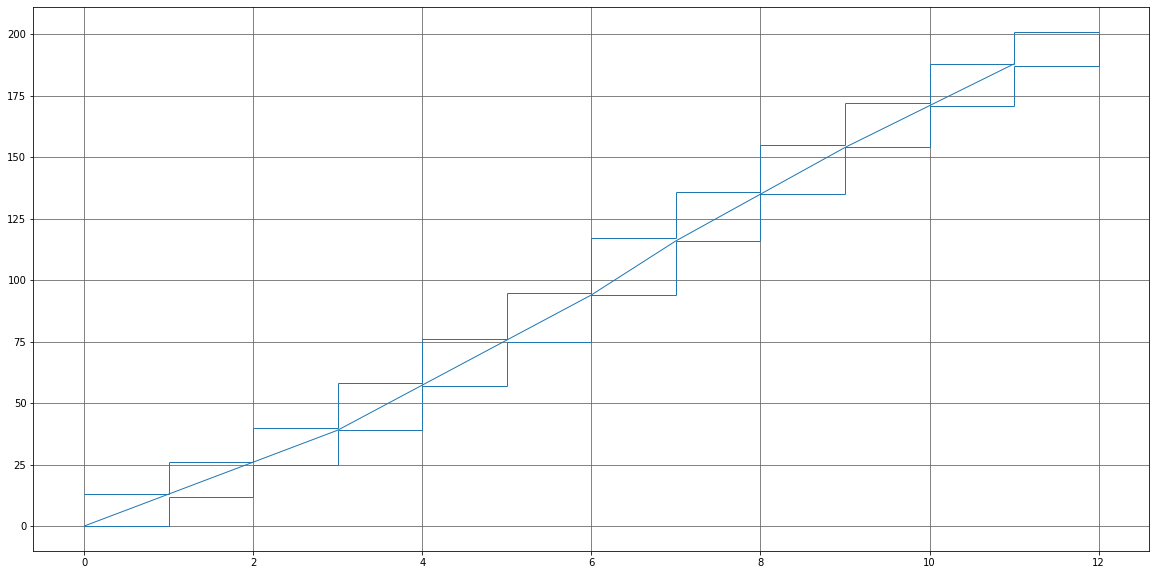

In [6]:
data1 = [1.2,1.3,1.4,1.8,1.8,1.9,2.2,1.9,1.9,1.7,1.6,1.3]
print(data1)
x,g1,g2,t,tpos,y,ycum = a_route_m(data1,3)
print(t)
print(tpos)
print(g1)
print(g2)
print(y)
graphA(x,g1,g2,t,tpos)

[1.0, 1.1, 0.3]
[2]
[1]
[0.0, 10.0, 21.0, 24.0]
[1.0, 11.0, 22.0, 25.0]
[ 0.  10.5 10.5  3.5]


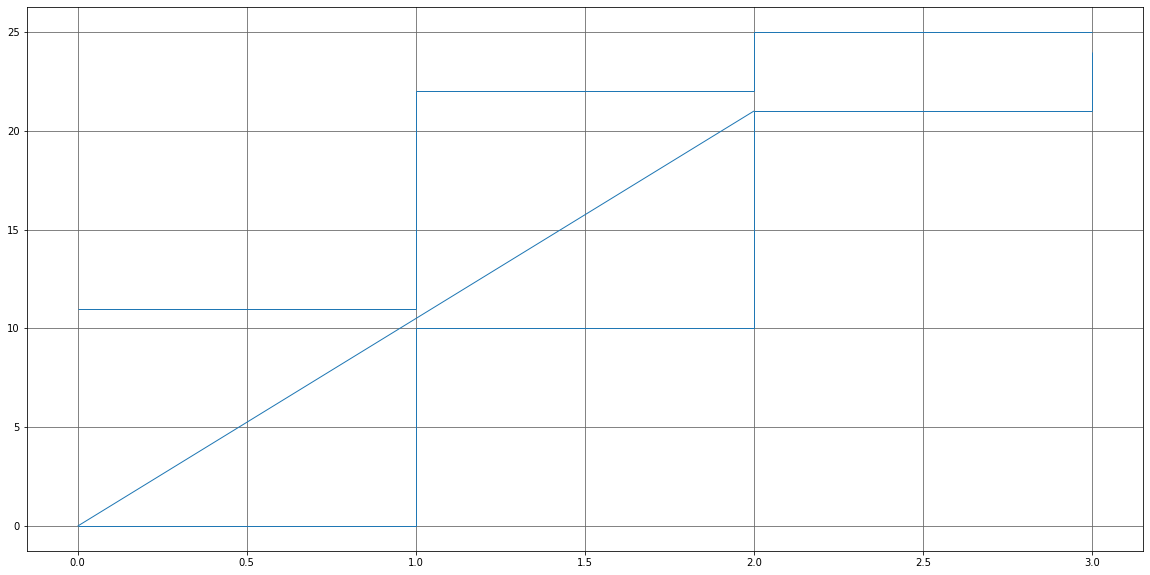

In [9]:
data2 = [1.0,1.1,0.3]
print(data2)
x,g1,g2,t,tpos,y,ycum = a_route_m(data2,3)
print(t)
print(tpos)
print(g1)
print(g2)
print(y)
graphA(x,g1,g2,t,tpos)